In [0]:
!pip install sqlalchemy
!pip install psycopg2
!pip install psycopg2-binary

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings



# import warnings
warnings.filterwarnings('ignore')

In [0]:
# Database credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df= pd.read_sql_query('select * from houseprices', con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [0]:
df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [0]:
df=pd.concat([df,pd.get_dummies(df.mszoning,prefix="mszoning",drop_first=True)], axis=1)
df=pd.concat([df,pd.get_dummies(df.street,prefix="street",drop_first=True)], axis=1)
dummy_column_names=list(pd.get_dummies(df.mszoning,prefix="mszoning",drop_first=True).columns)
dummy_column_names=dummy_column_names + list(pd.get_dummies(df.street,prefix="street",drop_first=True).columns)

In [0]:
#explanatory variables and target variable
X=df[["overallqual", "grlivarea" ,"garagecars","garagearea", "totalbsmtsf"] + dummy_column_names]
Y=df["saleprice"]


In [0]:

#split the data
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.2, random_state=465)


print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

# We add a constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

The number of observations in the training set is 1168
The number of observations in the test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Sat, 21 Mar 2020   Prob (F-statistic):               0.00
Time:                        04:00:29   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [0]:
#Assess the goodness of fit
#r squared is 0.768 which means 0.232 of the variance in the target variable is not explained by the model.



In [0]:
#Evaluating the test set

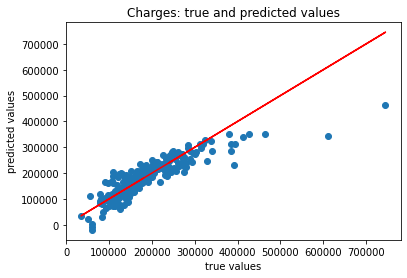

Mean absolute error of the prediction is: 25546.803828588643
Mean squared error of the prediction is: 1559083821.9730175
Root mean squared error of the prediction is: 39485.23549344764
Mean absolute percentage error of the prediction is: 15.551420347537665


In [0]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [0]:
#the the performance of the higher values is a bit poor but the performance of the model in general is relatively good. 

In [0]:
df["total_sf"]=df['firstflrsf'] + df['secondflrsf'] + df['totalbsmtsf']

df['int_over_sf']=df['total_sf'] *df['overallqual']


X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'total_sf', 'int_over_sf'] + dummy_column_names]
Y=np.log1p(df["saleprice"])
# We add a constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)
#split the data
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.2, random_state=465)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     520.9
Date:                Sat, 21 Mar 2020   Prob (F-statistic):               0.00
Time:                        05:00:17   Log-Likelihood:                 463.99
No. Observations:                1168   AIC:                            -904.0
Df Residuals:                    1156   BIC:                            -843.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.9162      0.102     97.518      

In [0]:
#Rsquared is higher and so is adjusted r squared. AIC and BIC are lower


In [0]:
#Let's try predicting

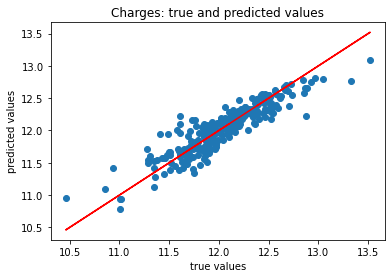

Mean absolute error of the prediction is: 0.12570372872852303
Mean squared error of the prediction is: 0.029192121871290135
Root mean squared error of the prediction is: 0.1708570217207655
Mean absolute percentage error of the prediction is: 1.0503577667817636


In [0]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [0]:
#The test evaluation metrics are better for the second case compared to the first case